In [9]:
# ================================
# 1. Data Retrieval and Preparation
# ================================

import os
from dotenv import load_dotenv
from tvDatafeed import TvDatafeedLive, Interval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import os

# Load environment variables from .env file
load_dotenv()

# Retrieve TradingView credentials from environment variables
username = os.environ.get("TRADINGVIEW_USERNAME")
password = os.environ.get("TRADINGVIEW_PASSWORD")

# Initialize TradingView live data feed
tv = TvDatafeedLive(username, password)

# Fetch historical data for XAUUSD (2000 hourly bars)
prices = tv.get_hist(symbol='XAUUSD', exchange='ICMARKETS',
                     interval=Interval.in_1_hour, n_bars=5000)

# Ensure the 'close' column is in numeric format
prices['close'] = pd.to_numeric(prices['close'], errors='coerce')

# Drop any rows with NaN values in 'close'
prices.dropna(subset=['close'], inplace=True)

# Reset index if necessary
prices.reset_index(drop=True, inplace=True)

# Verify total data points after cleaning
total_data_points = prices.shape[0]
print(f"Total data points after cleaning: {total_data_points}")

# ================================
# 2. Hyperparameter Optimization
# ================================

# Define error metric: Root Mean Squared Error (RMSE)
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Fixed parameters
fixed_train_size = 4000       # Fixed training size
fixed_seasonal = False        # Fixed seasonality
window_length = 19             # Fixed window_length for Savitzky-Golay filter
polyorder = 1                  # Fixed polyorder for Savitzky-Golay filter
forecast_elements = 20         # Number of data points to forecast (5 hours)
shift_step = 12                # Shift each run by 12 data points
num_runs = 40                  # Number of rolling window iterations

# Optimization variables
seasonal_data_lengths = [1200, 1600, 2000, 2400]
num_harmonics_list = [50, 60, 70, 80, 90]

# Create a directory to save plots
import os
plot_dir = "forecast_plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Initialize a list to store results
results = []

# Loop through each combination of seasonal_data_length and num_harmonics
for seasonal_data_length in seasonal_data_lengths:
    for num_harmonics in num_harmonics_list:
        rmse_list = []
        print(f"\nOptimizing for seasonal_data_length={seasonal_data_length}, num_harmonics={num_harmonics}...")
        
        for run in range(num_runs):
            # Define shift for rolling window
            shift = run * shift_step

            # Calculate indices for slicing using positive indices
            start_idx = total_data_points - (fixed_train_size + forecast_elements + shift)
            end_train_idx = total_data_points - (forecast_elements + shift)
            test_start_idx = end_train_idx
            test_end_idx = end_train_idx + forecast_elements

            # Ensure indices are within bounds
            if start_idx < 0 or test_end_idx > total_data_points:
                print(f"  Skipping run {run} due to insufficient data (shift={shift}).")
                continue

            # Slice the data for training and testing
            train_prices = prices.iloc[start_idx:end_train_idx].copy()
            test_prices = prices.iloc[test_start_idx:test_end_idx].copy()

            # Verify that slicing has the correct number of data points
            if len(train_prices) != fixed_train_size or len(test_prices) != forecast_elements:
                print(f"  Run {run} failed: Incorrect slice sizes (train_size={len(train_prices)}, test_size={len(test_prices)}).")
                rmse_list.append(np.nan)
                continue

            # Extract the trend component using Savitzky-Golay filter on training data
            try:
                trend_train = savgol_filter(train_prices['close'], window_length=window_length, polyorder=polyorder)
                # Subtract trend from original data to get the seasonal component
                seasonal_train = train_prices['close'].values - trend_train
            except ValueError as e:
                print(f"  Run {run} failed during Savitzky-Golay filter on training data: {e}")
                rmse_list.append(np.nan)
                continue

            # Fit Auto-ARIMA model on the trend component
            try:
                smodel = pm.auto_arima(
                    trend_train,
                    start_p=1, start_q=1,
                    max_p=4, max_q=4,
                    seasonal=fixed_seasonal,
                    m=24 if fixed_seasonal else 1,    # Set m=24 for daily seasonality if seasonal=True
                    d=None,
                    D=1 if fixed_seasonal else 0,
                    trace=False,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True
                )

                # Forecast the next 24 data points (trend_forecast)
                forecast_trend = smodel.predict(n_periods=forecast_elements)
            except Exception as e:
                print(f"  Run {run} failed during Auto-ARIMA fitting or forecasting: {e}")
                rmse_list.append(np.nan)
                continue

            # Seasonal Component Forecasting using FFT
            try:
                # Determine the starting index for the seasonal data
                if seasonal_data_length > len(seasonal_train):
                    print(f"  Run {run} failed: seasonal_data_length={seasonal_data_length} exceeds available data.")
                    rmse_list.append(np.nan)
                    continue

                # Extract the last 'seasonal_data_length' points for FFT
                seasonal_data_for_fft = seasonal_train[-seasonal_data_length:]

                # Time indices for the existing data
                N_seasonal = len(seasonal_data_for_fft)
                total_length = N_seasonal + forecast_elements
                extended_indices = np.arange(total_length)

                # Perform FFT on the seasonal data
                fft_result = np.fft.fft(seasonal_data_for_fft)
                fft_freq = np.fft.fftfreq(N_seasonal)

                # Only need positive frequencies
                positive_freq_indices = fft_freq >= 0
                fft_freq_positive = fft_freq[positive_freq_indices]
                fft_result_positive = fft_result[positive_freq_indices]

                # Retain only the first 'num_harmonics' harmonics
                if num_harmonics > len(fft_result_positive):
                    print(f"  Run {run} failed: num_harmonics={num_harmonics} exceeds available harmonics ({len(fft_result_positive)}).")
                    rmse_list.append(np.nan)
                    continue

                frequencies = fft_freq_positive[:num_harmonics]
                amplitudes = fft_result_positive[:num_harmonics]

                # Reconstruct the seasonal signal with forecast
                reconstructed_seasonal = np.zeros(total_length)

                for i in range(num_harmonics):
                    frequency = frequencies[i]
                    amplitude = amplitudes[i]
                    omega = 2 * np.pi * frequency
                    phase = np.angle(amplitude)
                    if frequency == 0:
                        # DC component
                        reconstructed_seasonal += amplitude.real / N_seasonal
                    else:
                        # Harmonic components
                        reconstructed_seasonal += (2 * np.abs(amplitude) / N_seasonal) * np.cos(omega * extended_indices + phase)

                # Extract the forecasted seasonal component
                seasonal_forecast = reconstructed_seasonal[-forecast_elements:]
            except Exception as e:
                print(f"  Run {run} failed during FFT processing: {e}")
                rmse_list.append(np.nan)
                continue

            # Combine the trend and seasonal forecasts
            total_forecast = forecast_trend + seasonal_forecast

            # Actual test data
            actual_values = test_prices['close'].values

            # Calculate RMSE between total forecast and actual test data
            rmse = calculate_rmse(actual_values, total_forecast)
            rmse_list.append(rmse)

            # ================================
            # 4. Visualization
            # ================================

            try:
                # Define the number of training points to plot
                plot_train_size = 240

                # Ensure that the last 'plot_train_size' data points are available
                if plot_train_size > len(train_prices):
                    plot_train_size = len(train_prices)

                # Extract the last 'plot_train_size' training data points
                plot_train_prices = train_prices.iloc[-plot_train_size:].copy()
                plot_test_prices = test_prices.copy()

                # Extract the corresponding trend
                plot_trend_train = trend_train[-plot_train_size:]
                plot_trend_forecast = forecast_trend

                # Extract the corresponding seasonal component
                plot_seasonal_train = seasonal_train[-plot_train_size:]
                plot_seasonal_forecast = seasonal_forecast

                # Combine train and test for plotting
                combined_plot_prices = np.concatenate([plot_train_prices['close'].values, plot_test_prices['close'].values])
                combined_trend = np.concatenate([plot_trend_train, plot_trend_forecast])
                combined_seasonal = np.concatenate([plot_seasonal_train, plot_seasonal_forecast])

                # Create a time index for plotting
                time_train = np.arange(-plot_train_size, 0)
                time_forecast = np.arange(0, forecast_elements)
                time_combined = np.concatenate([time_train, time_forecast])

                # Plotting
                plt.figure(figsize=(12, 6))
                plt.plot(time_combined, combined_plot_prices, label='Original Price', color='blue')
                plt.plot(time_combined, combined_trend, label='Trend', color='red')
                plt.plot(time_combined, combined_trend+combined_seasonal, label='Trend+Seasonal', color='green')
                plt.axvline(x=0, color='black', linestyle='--', label='Forecast Start')
                plt.title(f'Run {run} - Seasonal Data Length: {seasonal_data_length}, Harmonics: {num_harmonics}')
                plt.xlabel('Time (hours)')
                plt.ylabel('Price')
                plt.legend()
                plt.tight_layout()

                # Save the plot
                plot_filename = f"seasonal_length_{seasonal_data_length}_harmonics_{num_harmonics}_run_{run}.png"
                plt.savefig(os.path.join(plot_dir, plot_filename))
                plt.close()

            except Exception as e:
                print(f"  Run {run} failed during plotting: {e}")
                continue

        # Calculate average RMSE across all runs, ignoring NaN values
        if rmse_list:
            avg_rmse = np.nanmean(rmse_list)
        else:
            avg_rmse = np.nan

        # Store the results
        results.append({
            'seasonal_data_length': seasonal_data_length,
            'num_harmonics': num_harmonics,
            'avg_rmse': avg_rmse
        })

        print(f"  Completed: seasonal_data_length={seasonal_data_length}, num_harmonics={num_harmonics}, avg_rmse={avg_rmse:.4f}")

# ================================
# 3. Visualization of Results
# ================================

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Display the results
print("\nOptimization Results:")
print(results_df)

# Pivot the DataFrame for heatmap
pivot_table = results_df.pivot('seasonal_data_length', 'num_harmonics', 'avg_rmse')

# Set plot style
sns.set(style="whitegrid")

# Plot a heatmap of the results
plt.figure(figsize=(16, 10))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap='viridis')
plt.title('Average RMSE for Different Seasonal Data Lengths and Number of Harmonics')
plt.xlabel('Number of Harmonics')
plt.ylabel('Seasonal Data Length')
plt.show()


ERROR:tvDatafeed.main:error while signin


Total data points after cleaning: 5000

Optimizing for seasonal_data_length=1200, num_harmonics=50...
  Completed: seasonal_data_length=1200, num_harmonics=50, avg_rmse=12.6748

Optimizing for seasonal_data_length=1200, num_harmonics=60...
  Completed: seasonal_data_length=1200, num_harmonics=60, avg_rmse=12.7804

Optimizing for seasonal_data_length=1200, num_harmonics=70...
  Completed: seasonal_data_length=1200, num_harmonics=70, avg_rmse=13.0726

Optimizing for seasonal_data_length=1200, num_harmonics=80...
  Completed: seasonal_data_length=1200, num_harmonics=80, avg_rmse=13.1535

Optimizing for seasonal_data_length=1200, num_harmonics=90...
  Completed: seasonal_data_length=1200, num_harmonics=90, avg_rmse=13.2268

Optimizing for seasonal_data_length=1600, num_harmonics=50...
  Completed: seasonal_data_length=1600, num_harmonics=50, avg_rmse=11.6562

Optimizing for seasonal_data_length=1600, num_harmonics=60...
  Completed: seasonal_data_length=1600, num_harmonics=60, avg_rmse=11.

TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

In [10]:
results

[{'seasonal_data_length': 1200,
  'num_harmonics': 50,
  'avg_rmse': 12.674799736161692},
 {'seasonal_data_length': 1200,
  'num_harmonics': 60,
  'avg_rmse': 12.780378448887038},
 {'seasonal_data_length': 1200,
  'num_harmonics': 70,
  'avg_rmse': 13.072610047778278},
 {'seasonal_data_length': 1200,
  'num_harmonics': 80,
  'avg_rmse': 13.153532947912106},
 {'seasonal_data_length': 1200,
  'num_harmonics': 90,
  'avg_rmse': 13.226823229649739},
 {'seasonal_data_length': 1600,
  'num_harmonics': 50,
  'avg_rmse': 11.656176418815873},
 {'seasonal_data_length': 1600,
  'num_harmonics': 60,
  'avg_rmse': 11.699022706353967},
 {'seasonal_data_length': 1600,
  'num_harmonics': 70,
  'avg_rmse': 11.718874258780577},
 {'seasonal_data_length': 1600,
  'num_harmonics': 80,
  'avg_rmse': 11.775390196114412},
 {'seasonal_data_length': 1600,
  'num_harmonics': 90,
  'avg_rmse': 11.839180690286042},
 {'seasonal_data_length': 2000,
  'num_harmonics': 50,
  'avg_rmse': 12.09792020050371},
 {'seasonal

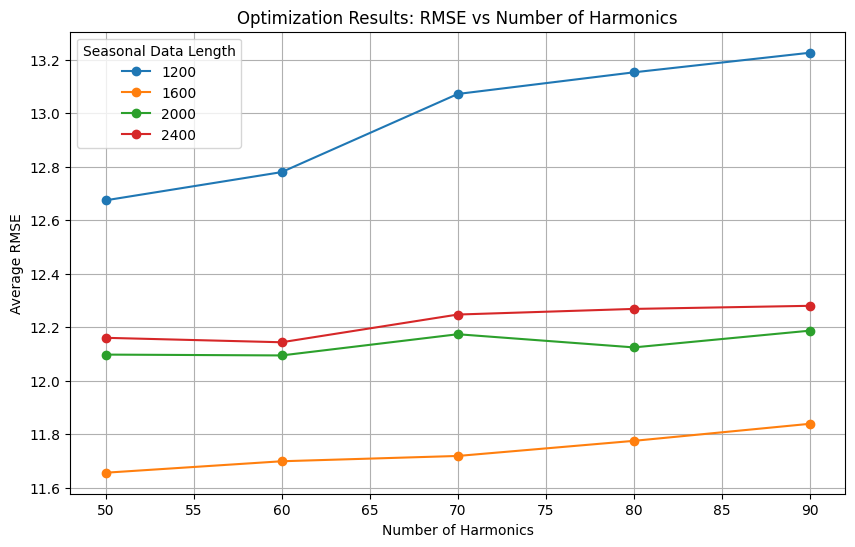

In [11]:
optimization_data = results
# Extracting data based on seasonal data length
num_harmonics_1200 = [entry['num_harmonics'] for entry in optimization_data if entry['seasonal_data_length'] == 1200]
rmse_1200 = [entry['avg_rmse'] for entry in optimization_data if entry['seasonal_data_length'] == 1200]

num_harmonics_1600 = [entry['num_harmonics'] for entry in optimization_data if entry['seasonal_data_length'] == 1600]
rmse_1600 = [entry['avg_rmse'] for entry in optimization_data if entry['seasonal_data_length'] == 1600]

num_harmonics_2000 = [entry['num_harmonics'] for entry in optimization_data if entry['seasonal_data_length'] == 2000]
rmse_2000 = [entry['avg_rmse'] for entry in optimization_data if entry['seasonal_data_length'] == 2000]

num_harmonics_2400 = [entry['num_harmonics'] for entry in optimization_data if entry['seasonal_data_length'] == 2400]
rmse_2400 = [entry['avg_rmse'] for entry in optimization_data if entry['seasonal_data_length'] == 2400]


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(num_harmonics_1200, rmse_1200, marker='o', label='1200')
plt.plot(num_harmonics_1600, rmse_1600, marker='o', label='1600')
plt.plot(num_harmonics_2000, rmse_2000, marker='o', label='2000')
plt.plot(num_harmonics_2400, rmse_2400, marker='o', label='2400')

plt.title('Optimization Results: RMSE vs Number of Harmonics')
plt.xlabel('Number of Harmonics')
plt.ylabel('Average RMSE')
plt.legend(title='Seasonal Data Length')
plt.grid(True)
plt.show()

In [4]:
results

[{'seasonal_data_length': 200,
  'num_harmonics': 10,
  'avg_rmse': 12.047556513338403},
 {'seasonal_data_length': 200,
  'num_harmonics': 20,
  'avg_rmse': 12.196927541278841},
 {'seasonal_data_length': 200,
  'num_harmonics': 30,
  'avg_rmse': 12.372701589721064},
 {'seasonal_data_length': 200,
  'num_harmonics': 40,
  'avg_rmse': 12.460624858350844},
 {'seasonal_data_length': 200,
  'num_harmonics': 50,
  'avg_rmse': 12.538736671495183},
 {'seasonal_data_length': 200,
  'num_harmonics': 60,
  'avg_rmse': 12.602493463362984}]

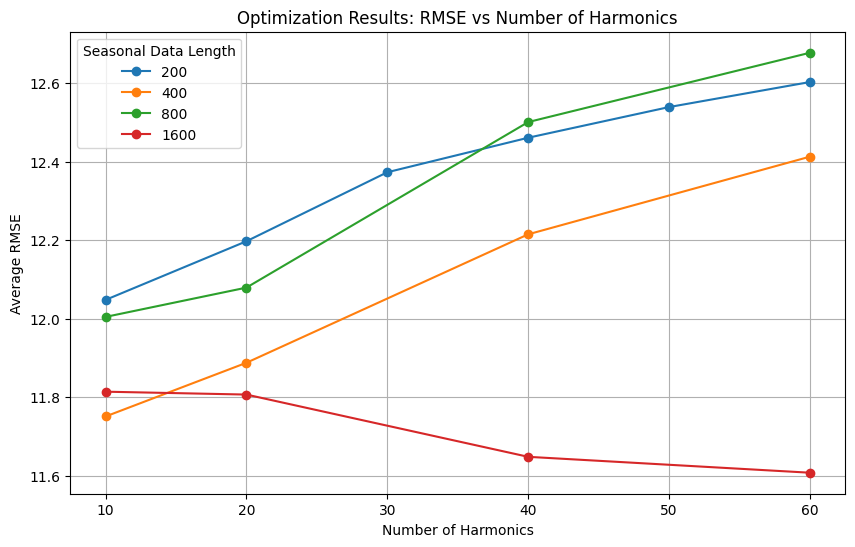

In [7]:
optimization_data = [
    {'seasonal_data_length': 200,
  'num_harmonics': 10,
  'avg_rmse': 12.047556513338403},
 {'seasonal_data_length': 200,
  'num_harmonics': 20,
  'avg_rmse': 12.196927541278841},
 {'seasonal_data_length': 200,
  'num_harmonics': 30,
  'avg_rmse': 12.372701589721064},
 {'seasonal_data_length': 200,
  'num_harmonics': 40,
  'avg_rmse': 12.460624858350844},
 {'seasonal_data_length': 200,
  'num_harmonics': 50,
  'avg_rmse': 12.538736671495183},
 {'seasonal_data_length': 200,
  'num_harmonics': 60,
  'avg_rmse': 12.602493463362984},
    {'seasonal_data_length': 400, 'num_harmonics': 10, 'avg_rmse': 11.750672},
    {'seasonal_data_length': 400, 'num_harmonics': 20, 'avg_rmse': 11.887456},
    {'seasonal_data_length': 400, 'num_harmonics': 40, 'avg_rmse': 12.214650},
    {'seasonal_data_length': 400, 'num_harmonics': 60, 'avg_rmse': 12.412462},
    {'seasonal_data_length': 800, 'num_harmonics': 10, 'avg_rmse': 12.004252},
    {'seasonal_data_length': 800, 'num_harmonics': 20, 'avg_rmse': 12.078875},
    {'seasonal_data_length': 800, 'num_harmonics': 40, 'avg_rmse': 12.500528},
    {'seasonal_data_length': 800, 'num_harmonics': 60, 'avg_rmse': 12.677086},
    {'seasonal_data_length': 1600, 'num_harmonics': 10, 'avg_rmse': 11.813816},
    {'seasonal_data_length': 1600, 'num_harmonics': 20, 'avg_rmse': 11.806496},
    {'seasonal_data_length': 1600, 'num_harmonics': 40, 'avg_rmse': 11.647931},
    {'seasonal_data_length': 1600, 'num_harmonics': 60, 'avg_rmse': 11.607453}
]

# Extracting data based on seasonal data length
num_harmonics_200 = [entry['num_harmonics'] for entry in optimization_data if entry['seasonal_data_length'] == 200]
rmse_200 = [entry['avg_rmse'] for entry in optimization_data if entry['seasonal_data_length'] == 200]

num_harmonics_400 = [entry['num_harmonics'] for entry in optimization_data if entry['seasonal_data_length'] == 400]
rmse_400 = [entry['avg_rmse'] for entry in optimization_data if entry['seasonal_data_length'] == 400]

num_harmonics_800 = [entry['num_harmonics'] for entry in optimization_data if entry['seasonal_data_length'] == 800]
rmse_800 = [entry['avg_rmse'] for entry in optimization_data if entry['seasonal_data_length'] == 800]

num_harmonics_1600 = [entry['num_harmonics'] for entry in optimization_data if entry['seasonal_data_length'] == 1600]
rmse_1600 = [entry['avg_rmse'] for entry in optimization_data if entry['seasonal_data_length'] == 1600]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(num_harmonics_200, rmse_200, marker='o', label='200')
plt.plot(num_harmonics_400, rmse_400, marker='o', label='400')
plt.plot(num_harmonics_800, rmse_800, marker='o', label='800')
plt.plot(num_harmonics_1600, rmse_1600, marker='o', label='1600')

plt.title('Optimization Results: RMSE vs Number of Harmonics')
plt.xlabel('Number of Harmonics')
plt.ylabel('Average RMSE')
plt.legend(title='Seasonal Data Length')
plt.grid(True)
plt.show()